In [1]:
# === Cellule 1 : Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from xgboost import XGBClassifier
import joblib

# Chargement des données finales
df = pd.read_csv("nhanes_ready.csv")
print("Données chargées :", df.shape)


Données chargées : (6889, 38)


In [2]:
# Cellule 2 :

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6889 entries, 0 to 6888
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SEQN                        6889 non-null   float64
 1   RIDAGEYR                    6889 non-null   float64
 2   RIAGENDR                    6889 non-null   int64  
 3   LBXTC                       6889 non-null   float64
 4   BMXHT                       6889 non-null   float64
 5   BMXBMI                      6889 non-null   float64
 6   BMXWT                       6889 non-null   float64
 7   BMXWAIST                    6889 non-null   float64
 8   BMXARMC                     6889 non-null   float64
 9   PAD680                      6889 non-null   float64
 10  SLD012                      6889 non-null   float64
 11  DRKCAL                      6889 non-null   float64
 12  DRPROT                      6889 non-null   float64
 13  DRSUGR                      6889 

In [3]:
# Cellule 3 : NaN

df.isna().sum().sum()


np.int64(0)

In [4]:
# Cellule 4 : doublons

df.duplicated().sum()


np.int64(0)

In [5]:
# Cellule 5 : Définition des features et de la cible ===

target = "chol_high"
features = ["RIDAGEYR", "RIAGENDR", "diabetes", "BMXBMI_log", "BMXHT", "BMXWT", "BMXWAIST", "BMXARMC",
            "PAD680_log", "SLD012", "DRKCAL_log", "DRPROT_log", "DRSUGR_log", "DRFIBE_log", "DRTFAT_log",
            "DRCARB_log", "DRWATER_log", "DRTALCO_log", "smoker", "ethnicity_MexicanAmerican",
            "ethnicity_NonHispanicAsian", "ethnicity_NonHispanicBlack", "ethnicity_NonHispanicWhite",
            "ethnicity_OtherHispanic", "ethnicity_OtherRace"
           ] 


X = df[features]
y = df[target]

print(" Variables prêtes pour la modélisation")
print(f"Nombre de features : {X.shape[1]}")
print(f"Nombre d'observations : {X.shape[0]}")
print(f"Variable cible : {target}")

# Vérification de la répartition de la cible
print("Répartition de la variable cible :")
print(y.value_counts())
print("Pourcentages :")
print((y.value_counts(normalize=True) * 100).round(2))


 Variables prêtes pour la modélisation
Nombre de features : 25
Nombre d'observations : 6889
Variable cible : chol_high
Répartition de la variable cible :
chol_high
0    6272
1     617
Name: count, dtype: int64
Pourcentages :
chol_high
0    91.04
1     8.96
Name: proportion, dtype: float64


In [7]:
# Cellule 6 : Split stratifié train/val/test 

# Étape 1 : découpage train + test (80/20)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Étape 2 : découpage train + val (sur les 80 % restants)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.25,   # 25 % de 80 % = 20 % du total
    stratify=y_train_full,
    random_state=42
)

print(" Split effectué :")
print(f"Train : {X_train.shape[0]} individus ({(X_train.shape[0]/len(X))*100:.1f} %)")
print(f"Validation : {X_val.shape[0]} individus ({(X_val.shape[0]/len(X))*100:.1f} %)")
print(f"Test : {X_test.shape[0]} individus ({(X_test.shape[0]/len(X))*100:.1f} %)")

print("Répartition des classes :")
print("Train :", y_train.value_counts(normalize=True).round(3).to_dict())
print("Val   :", y_val.value_counts(normalize=True).round(3).to_dict())
print("Test  :", y_test.value_counts(normalize=True).round(3).to_dict())


 Split effectué :
Train : 4133 individus (60.0 %)
Validation : 1378 individus (20.0 %)
Test : 1378 individus (20.0 %)
Répartition des classes :
Train : {0: 0.91, 1: 0.09}
Val   : {0: 0.91, 1: 0.09}
Test  : {0: 0.911, 1: 0.089}


In [8]:
# Cellule 7 : Standardisation des variables numériques
from sklearn.preprocessing import StandardScaler

# Colonnes binaires à NE PAS standardiser
binary_cols = [
    "RIAGENDR", "diabetes", "smoker",
    "ethnicity_MexicanAmerican", "ethnicity_NonHispanicAsian",
    "ethnicity_NonHispanicBlack", "ethnicity_NonHispanicWhite",
    "ethnicity_OtherHispanic", "ethnicity_OtherRace"
]

# Colonnes numériques à standardiser (toutes les autres)
num_cols = [col for col in X_train.columns if col not in binary_cols]

print(f"Nombre de colonnes à standardiser : {len(num_cols)}")
print(num_cols)

# Initialisation du scaler
scaler = StandardScaler()

# Fit sur le train uniquement
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

# Application sur val et test avec les mêmes paramètres
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Sauvegarde du scaler pour réutilisation (API, etc.)
joblib.dump(scaler, "scaler_chol.pkl")

print("Standardisation effectuée uniquement sur le train")
print("Scaler sauvegardé : scaler_chol.pkl")
print(f"Dimensions finales — X_train : {X_train.shape}, X_val : {X_val.shape}, X_test : {X_test.shape}")


Nombre de colonnes à standardiser : 16
['RIDAGEYR', 'BMXBMI_log', 'BMXHT', 'BMXWT', 'BMXWAIST', 'BMXARMC', 'PAD680_log', 'SLD012', 'DRKCAL_log', 'DRPROT_log', 'DRSUGR_log', 'DRFIBE_log', 'DRTFAT_log', 'DRCARB_log', 'DRWATER_log', 'DRTALCO_log']
Standardisation effectuée uniquement sur le train
Scaler sauvegardé : scaler_chol.pkl
Dimensions finales — X_train : (4133, 25), X_val : (1378, 25), X_test : (1378, 25)


In [9]:
# Cellule 8 : Vérification de la standardisation 

# On vérifie la moyenne et l'écart-type dans le jeu d'entraînement
stats = pd.DataFrame({
    "mean": X_train[num_cols].mean().round(2),
    "std": X_train[num_cols].std().round(2)
})

print("=== Vérification standardisation (train uniquement) ===")
display(stats)

# Vérification rapide sur val/test
mean_val = np.abs(X_val[num_cols].mean()).mean().round(2)
std_val = X_val[num_cols].std().mean().round(2)

mean_test = np.abs(X_test[num_cols].mean()).mean().round(2)
std_test = X_test[num_cols].std().mean().round(2)

print(f"\nValidation : moyenne abs = {mean_val}, écart-type moyen = {std_val}")
print(f"Test : moyenne abs = {mean_test}, écart-type moyen = {std_test}")


=== Vérification standardisation (train uniquement) ===


,mean,std
RIDAGEYR,0.0,1.0
BMXBMI_log,-0.0,1.0
BMXHT,-0.0,1.0
BMXWT,-0.0,1.0
BMXWAIST,0.0,1.0
BMXARMC,-0.0,1.0
PAD680_log,-0.0,1.0
SLD012,-0.0,1.0
DRKCAL_log,0.0,1.0
DRPROT_log,0.0,1.0



Validation : moyenne abs = 0.03, écart-type moyen = 1.0
Test : moyenne abs = 0.02, écart-type moyen = 0.97


Ratio classe majoritaire / minoritaire : 10.17
[0]	validation_0-auc:0.76211	validation_1-auc:0.66727
[50]	validation_0-auc:0.84139	validation_1-auc:0.71850
[89]	validation_0-auc:0.84957	validation_1-auc:0.72044
Modèle XGBoost entraîné et sauvegardé : xgb_chol_model.pkl
=== Rapport de classification ===
              precision    recall  f1-score   support

           0      0.958     0.598     0.736      1255
           1      0.151     0.732     0.251       123

    accuracy                          0.610      1378
   macro avg      0.555     0.665     0.493      1378
weighted avg      0.886     0.610     0.693      1378

=== Matrice de confusion ===
[[750 505]
 [ 33  90]]
AUC ROC : 0.718


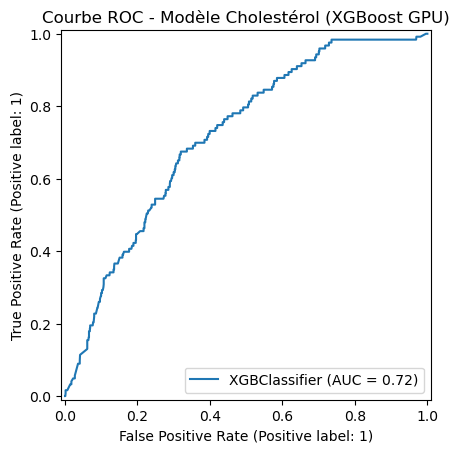

In [22]:
# Cellule 9 : XGBoost GPU avec learning rate adaptatif ===


# Poids pour classes déséquilibrées
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Ratio classe majoritaire / minoritaire : {ratio:.2f}")

# Modèle XGBoost optimisé
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    device="cuda",                 # GPU activé ici
    eval_metric="auc",
    scale_pos_weight=ratio,
    learning_rate=0.005,            # learning rate adaptatif via early stopping
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    n_estimators=1000,
    early_stopping_rounds=50,
    random_state=42,
    verbosity=1
)

# Entraînement
eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_clf.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=50
)

# Sauvegarde du modèle
joblib.dump(xgb_clf, "xgb_chol_model.pkl")
print("Modèle XGBoost entraîné et sauvegardé : xgb_chol_model.pkl")

# Évaluation
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:, 1]

print("=== Rapport de classification ===")
print(classification_report(y_test, y_pred, digits=3))

print("=== Matrice de confusion ===")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"AUC ROC : {roc_auc:.3f}")

# Courbe ROC
RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)
plt.title("Courbe ROC - Modèle Cholestérol (XGBoost GPU)")
plt.show()


In [24]:
# Cellule 10: Application de SMOTE sur le jeu d'entraînement 

from imblearn.over_sampling import SMOTE
from collections import Counter

# Vérification du déséquilibre initial
print("Répartition initiale (train) :")
print(Counter(y_train))

# Application du sur-échantillonnage SMOTE
sm = SMOTE(random_state=42, k_neighbors=5)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Vérification après équilibrage
print("Répartition après SMOTE :")
print(Counter(y_train_res))

print(f" Jeu d'entraînement équilibré — X_train_res shape = {X_train_res.shape}")


Répartition initiale (train) :
Counter({0: 3763, 1: 370})
Répartition après SMOTE :
Counter({0: 3763, 1: 3763})
 Jeu d'entraînement équilibré — X_train_res shape = (7526, 25)


In [25]:
# Cellule 11 : verification 1

# Avant SMOTE
print("=== Avant SMOTE ===")
print(pd.DataFrame(X_train).describe().T[['mean', 'std', 'min', 'max']].round(2))

# Après SMOTE
print("\n=== Après SMOTE ===")
print(pd.DataFrame(X_train_res).describe().T[['mean', 'std', 'min', 'max']].round(2))


=== Avant SMOTE ===
             mean   std    min   max
RIDAGEYR     0.00  1.00  -1.77  1.51
RIAGENDR     1.54  0.50   1.00  2.00
diabetes     0.11  0.31   0.00  1.00
BMXBMI_log  -0.00  1.00  -2.95  3.64
BMXHT       -0.00  1.00  -4.46  2.78
BMXWT       -0.00  1.00  -2.48  5.93
BMXWAIST     0.00  1.00  -2.79  4.38
BMXARMC     -0.00  1.00  -2.89  5.29
PAD680_log  -0.00  1.00  -8.46  5.16
SLD012      -0.00  1.00  -3.95  4.27
DRKCAL_log   0.00  1.00 -19.19  3.83
DRPROT_log   0.00  1.00 -10.12  3.92
DRSUGR_log  -0.00  1.00  -7.83  4.10
DRFIBE_log   0.00  1.00  -5.82  3.66
DRTFAT_log   0.00  1.00  -9.48  3.63
DRCARB_log   0.00  1.00 -12.64  4.35
DRWATER_log -0.00  1.00  -3.73  2.07
DRTALCO_log -0.00  1.00  -0.45  4.00
smoker       0.32  0.47   0.00  1.00

=== Après SMOTE ===
             mean   std    min   max
RIDAGEYR     0.19  0.86  -1.77  1.51
RIAGENDR     1.54  0.50   1.00  2.00
diabetes     0.07  0.25   0.00  1.00
BMXBMI_log   0.08  0.92  -2.95  3.64
BMXHT        0.05  0.88  -4.46  2.

In [26]:
# Cellule 12 : verif 2

corr_before = X_train.corr()
corr_after = X_train_res.corr()

diff_corr = (corr_after - corr_before).abs().mean().mean()
print(f"Différence moyenne de corrélation entre avant/après SMOTE : {diff_corr:.3f}")


Différence moyenne de corrélation entre avant/après SMOTE : 0.027


In [27]:
# Cellule 13 : Correction post-SMOTE des colonnes binaires et catégorielles ===

# Colonnes binaires (valeurs attendues 0 ou 1)
binary_cols_01 = [
    "smoker", "diabetes",
    "ethnicity_MexicanAmerican", "ethnicity_NonHispanicAsian",
    "ethnicity_NonHispanicBlack", "ethnicity_NonHispanicWhite",
    "ethnicity_OtherHispanic", "ethnicity_OtherRace"
]

# Colonnes catégorielles à valeurs entières spécifiques (1 = Male, 2 = Female)
categorical_int_cols = ["RIAGENDR"]

# Arrondi et reformatage des binaires
X_train_res[binary_cols_01] = (
    X_train_res[binary_cols_01]
    .round()
    .clip(0, 1)   # sécurité si valeurs légèrement <0 ou >1
    .astype(int)
)

# Arrondi et reformatage des colonnes catégorielles
X_train_res[categorical_int_cols] = (
    X_train_res[categorical_int_cols]
    .round()
    .clip(1, 2)   # car seules 1 et 2 sont valides
    .astype(int)
)

# Vérification du résultat
print("Vérification des valeurs uniques après correction :\n")
for col in binary_cols_01 + categorical_int_cols:
    print(f"{col} → {sorted(X_train_res[col].unique())}")


Vérification des valeurs uniques après correction :

smoker → [np.int64(0), np.int64(1)]
diabetes → [np.int64(0), np.int64(1)]
ethnicity_MexicanAmerican → [np.int64(0), np.int64(1)]
ethnicity_NonHispanicAsian → [np.int64(0), np.int64(1)]
ethnicity_NonHispanicBlack → [np.int64(0), np.int64(1)]
ethnicity_NonHispanicWhite → [np.int64(0), np.int64(1)]
ethnicity_OtherHispanic → [np.int64(0), np.int64(1)]
ethnicity_OtherRace → [np.int64(0), np.int64(1)]
RIAGENDR → [np.int64(1), np.int64(2)]


In [38]:
# Cellule 14 : XGBoost optimisé pour le recall (compatible XGBoost ≥ 3.0)

# Instanciation du modèle avec early stopping dans les paramètres
xgb_recall = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",              # ou "gpu_hist" si GPU dispo
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.8,
    n_estimators=600,
    early_stopping_rounds=100,        
    random_state=42
)

# Entraînement
xgb_recall.fit(
    X_train_res, y_train_res,
    eval_set=[(X_train_res, y_train_res), (X_val, y_val)],
    verbose=25
)


[0]	validation_0-auc:0.80935	validation_1-auc:0.68073
[25]	validation_0-auc:0.92226	validation_1-auc:0.69989
[50]	validation_0-auc:0.95815	validation_1-auc:0.71539
[75]	validation_0-auc:0.97732	validation_1-auc:0.72245
[100]	validation_0-auc:0.98419	validation_1-auc:0.72438
[125]	validation_0-auc:0.98768	validation_1-auc:0.72518
[150]	validation_0-auc:0.99068	validation_1-auc:0.72557
[175]	validation_0-auc:0.99253	validation_1-auc:0.72525
[200]	validation_0-auc:0.99430	validation_1-auc:0.72443
[225]	validation_0-auc:0.99568	validation_1-auc:0.72500
[238]	validation_0-auc:0.99628	validation_1-auc:0.72375


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,'auc'


=== Rapport de classification (seuil 0.3) ===
              precision    recall  f1-score   support

           0      0.947     0.756     0.841      1255
           1      0.186     0.569     0.281       123

    accuracy                          0.739      1378
   macro avg      0.567     0.663     0.561      1378
weighted avg      0.879     0.739     0.791      1378

=== Matrice de confusion ===
[[949 306]
 [ 53  70]]
AUC ROC : 0.723


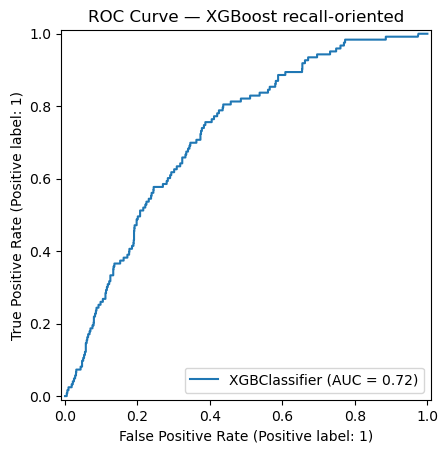

In [41]:
# Cellule : Évaluation finale sur le test set ===
y_pred_proba = xgb_recall.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.3).astype(int)  

print("=== Rapport de classification (seuil 0.3) ===")
print(classification_report(y_test, y_pred, digits=3))

print("=== Matrice de confusion ===")
print(confusion_matrix(y_test, y_pred))

print(f"AUC ROC : {roc_auc_score(y_test, y_pred_proba):.3f}")

# Courbe ROC
RocCurveDisplay.from_estimator(xgb_recall, X_test, y_test)
plt.title("ROC Curve — XGBoost recall-oriented")
plt.show()


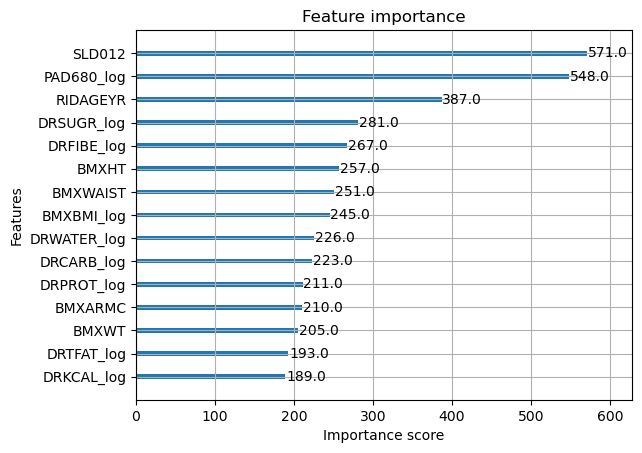

In [43]:
# Cellule 16 : importance des features 

import xgboost as xgb

xgb.plot_importance(xgb_recall, max_num_features=15)
plt.show()


In [44]:
# === Cellule : Modèle allégé (top features) avec undersampling + comparaison SMOTE ===

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Sélection des top features
top_features = [
    'SLD012','PAD680_log','RIDAGEYR','DRSUGR_log','DRFIBE_log',
    'BMXHT','BMXWAIST','BMXBMI_log','DRWATER_log','DRCARB_log'
]

X_train_light = X_train[top_features].copy()
X_val_light   = X_val[top_features].copy()
X_test_light  = X_test[top_features].copy()

# Undersampling doux
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_light, y_train)

# Modèle XGBoost optimisé pour recall
xgb_light = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    learning_rate=0.03,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.8,
    n_estimators=800,
    random_state=42
)

xgb_light.fit(X_train_rus, y_train_rus, eval_set=[(X_val_light, y_val)], verbose=False)

# Évaluation
y_pred_proba = xgb_light.predict_proba(X_test_light)[:, 1]
y_pred = (y_pred_proba >= 0.3).astype(int)

print("=== RUS - Rapport (seuil 0.3) ===")
print(classification_report(y_test, y_pred, digits=3))
print("AUC :", round(roc_auc_score(y_test, y_pred_proba), 3))

# Comparaison SMOTE
sm = SMOTE(random_state=42, k_neighbors=5)
X_train_sm, y_train_sm = sm.fit_resample(X_train_light, y_train)

xgb_smote = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    learning_rate=0.03,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.8,
    n_estimators=800,
    random_state=42
)

xgb_smote.fit(X_train_sm, y_train_sm, eval_set=[(X_val_light, y_val)], verbose=False)

y_pred_proba_sm = xgb_smote.predict_proba(X_test_light)[:, 1]
y_pred_sm = (y_pred_proba_sm >= 0.3).astype(int)

print("\n=== SMOTE - Rapport (seuil 0.3) ===")
print(classification_report(y_test, y_pred_sm, digits=3))
print("AUC :", round(roc_auc_score(y_test, y_pred_proba_sm), 3))


=== RUS - Rapport (seuil 0.3) ===
              precision    recall  f1-score   support

           0      0.948     0.648     0.770      1255
           1      0.150     0.634     0.243       123

    accuracy                          0.647      1378
   macro avg      0.549     0.641     0.506      1378
weighted avg      0.876     0.647     0.722      1378

AUC : 0.704

=== SMOTE - Rapport (seuil 0.3) ===
              precision    recall  f1-score   support

           0      0.928     0.864     0.895      1255
           1      0.186     0.317     0.234       123

    accuracy                          0.815      1378
   macro avg      0.557     0.590     0.564      1378
weighted avg      0.862     0.815     0.836      1378

AUC : 0.712


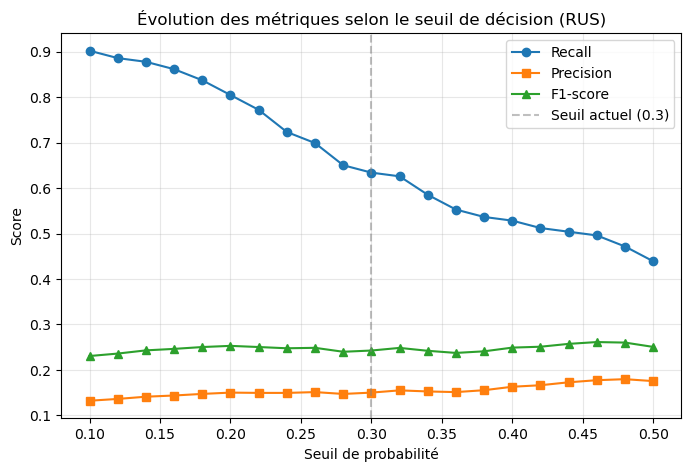

 Seuil optimal = 0.18
Recall = 0.837, Precision = 0.147, F1 = 0.250

=== Rapport à seuil optimal ===
              precision    recall  f1-score   support

           0      0.971     0.524     0.681      1255
           1      0.147     0.837     0.250       123

    accuracy                          0.552      1378
   macro avg      0.559     0.681     0.466      1378
weighted avg      0.897     0.552     0.642      1378

Matrice de confusion :
 [[658 597]
 [ 20 103]]


In [45]:
# === Cellule : Analyse du seuil de décision (modèle RUS) ===

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# On part du modèle déjà entraîné : xgb_light (RUS)
y_proba = xgb_light.predict_proba(X_test_light)[:, 1]

thresholds = np.arange(0.1, 0.51, 0.02)
recalls, precisions, f1s = [], [], []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    recalls.append(recall_score(y_test, y_pred_t))
    precisions.append(precision_score(y_test, y_pred_t))
    f1s.append(f1_score(y_test, y_pred_t))

# Visualisation
plt.figure(figsize=(8, 5))
plt.plot(thresholds, recalls, label="Recall", marker='o')
plt.plot(thresholds, precisions, label="Precision", marker='s')
plt.plot(thresholds, f1s, label="F1-score", marker='^')
plt.axvline(0.3, color='gray', linestyle='--', alpha=0.5, label="Seuil actuel (0.3)")
plt.xlabel("Seuil de probabilité")
plt.ylabel("Score")
plt.title("Évolution des métriques selon le seuil de décision (RUS)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Trouver le seuil optimal pour maximiser le recall avec un F1-score décent
best_idx = np.argmax([r if f > 0.25 else 0 for r, f in zip(recalls, f1s)])
best_threshold = thresholds[best_idx]

print(f" Seuil optimal = {best_threshold:.2f}")
print(f"Recall = {recalls[best_idx]:.3f}, Precision = {precisions[best_idx]:.3f}, F1 = {f1s[best_idx]:.3f}")

# Rapport détaillé à ce seuil
y_pred_best = (y_proba >= best_threshold).astype(int)
from sklearn.metrics import classification_report, confusion_matrix
print("\n=== Rapport à seuil optimal ===")
print(classification_report(y_test, y_pred_best, digits=3))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_best))
